# RE Biological Detector Using FastAI Vision
> "As part of FastAI DL Course 4 and inspired by Resident Evil 3, we will be creating a Resident Evil Bio Weapon Detector using FastAI Vision. Best tool for the zombie apocalypse!!"

- toc: false
- badges: true
- comments: false
- categories: [fastai, resident evil, vision]
- hide: false
- search_exclude: false

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1]:
#hide
import os
from PIL import Image
from utils import *
from fastai.vision.widgets import *

## Resident Evil Biological Detector

It was April 12, 2021, 8PM as I started my first playthrough of Resident Evil 3 remake, playing as Jill Valentine S.T.A.R.S. of the Racoon City Police Department you start to realize how bad the situation is right from the beginning of the game you get to see everything that is going on in the city; zombies everywhere people running scared and all of a sudden the wall explodes and Jill has one more thing to to worry about.

**NEMESIS**.
![nemesis](https://pbs.twimg.com/media/Ey6IrwvVcAIV5TL?format=jpg&name=4096x4096)

That big ugly thing that is all of a sudden chasing you everywhere you go and the first question Jill asks was:
> "What the hell is that thing?"

And I was well yeah what is that thing there is a big ugly powerful monster chasing me...It would be very helpful I knew what it was maybe just to know what can I do to protect myself and that's how I thought well maybe its time we give our fellow S.T.A.R.S. members some help to identify those creatures that way at least they know what they are fighting against.

### Background

I recently restarted the **[FastAI Course V4](https://course.fast.ai/)** with **Jeremy Howard, Rachel Thomas and Sylvain Gugger**, I originally took the live version in 2020 but due to the pandemic it was all done remote. 

I finished the whole course with them and it was great but there was a lot of information to process for my little brain, so I decided to stop and restart later once they published the new version.

After a while I decided to get back on DL and restart the whole course and in the course it was recommended us to create a blog, which is the main reason for me to pursue this as well. Needless to say that I will blogging about the entire experience and exercises of the FastAI course.

Finally, I want to take this time to thank the course instructors **Jeremy, Rachel and Sylvain** for inspiring us (your students) to blog, try, learn something new and also to make DL and ML more accessible to a lot of people and easy to understand, Thanks You.

And so without further ado lets get started...

### Data Gathering
Since I don't have a data set of Resident Evil creatures (although Umbrella for sure has one), I'm going to be searching images that I can use to identify all these creatures and use those for training and validation set. The FastBook included a couple functions that we can use to accomplish this by using third party search APIs. FastBook has 2 API functions, one for bing and one for duck duck go. We can use either of those to build our data set for our prototype.

In [2]:
# Here we are just defining the different categories we will use for our images and monsters and
# we are defining a path so that they can be saved locally
monster_labels = 't-type nemesis','licker','hunter','zombie', 'cerberus'
path = Path('storage/resident_evil/monsters')

The next lines of code will perform a search of the different monsters and download each under the folder names that we will be using for labeling later. Labeling data is very important and FastAI has several APIs that you can use to pass the labels to the data set, this is just one of the many ways we can do it.

In [3]:
#hide_output
if not path.exists():
    path.mkdir()
    
for o in monster_labels:
    dest = (path/o)
    if not dest.exists():
        dest.mkdir(exist_ok=True)
        # This is the duck duck go image search but FastBook included other to use Bing
        results = search_images_ddg(f'Resident Evil {o}')
        download_images(dest, urls=results)

### Data preprocessing
As part of the download we will start by cleaning up and validating out images. The get_image_files() function is used for obtaining the image path and the we will execute the verify_images() function after to make sure we remove all the images that can't be opened.

This is a pretty useful function since it will allow us to clear our already issues with some of our data.

In [4]:
#hide_output
fns = get_image_files(path) # Returns a list of file names with paths
failed = verify_images(fns) # Function will find images that cant be opened
failed

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

In [5]:
#hide_output
failed.map(Path.unlink);

In [6]:
#hide
# The next functions are used for the clean up of images, it seems that transparencies are problematic
for o in monster_labels:
    imageFolder = (path/o)
    listImages = os.listdir(imageFolder)
    
    for fn in listImages:
        if not os.path.isdir(fn):
            imgPath = os.path.join(imageFolder,fn)
            try:
                img = Image.open(imgPath)
                if img.mode != 'RGB': img.convert('RGB').save(fn)
            except ValueError as err:
                print(err)
                print("Error on image: ", imgPath)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:1007: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


### Datablock Definition
The DataBlock API I understand it as a major link in all the FastAI libraries. This API will be in charge of a lot of things: 

* Defining our data set type (image vs tabular)
* How do access or read the data
* Where/How do we use our labels
* How should FastAI split the data used for validation and training
* Define transformers applied to the items (data)

The next lines of code we will be using the data block API to generate a new type of block that will use a single category and use images for the data. We will obtain items using the get_image_files function and split the validation data set to a .3 percent, the label data will be obtained via the parent folder and finally we will define a transform that will randomly crop and resize images to 128


In [7]:
monsters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128))

### About Data Augmentation
As part of training our model, we explored only a little of data augmentation in the course. The concept is that a deep learning model will produce better results if we help our model generalize better vs making it memorize the data which will render our model useless since we want to be able to predict images it has never seen.

This is where data augmentation comes into play; by applying transformations to our data we can provide a different perspective on the data used by the model which should help us avoid over fitting, since although we might be showing the same image several times we are transforming as we use it, providing the model with access to new data that might help improve the performance of the model.

In [8]:
# These lines will create a data loader and show the train batch 
# and we can see the how the RandomResizeCrop works with an image
dls = monsters.dataloaders(path)

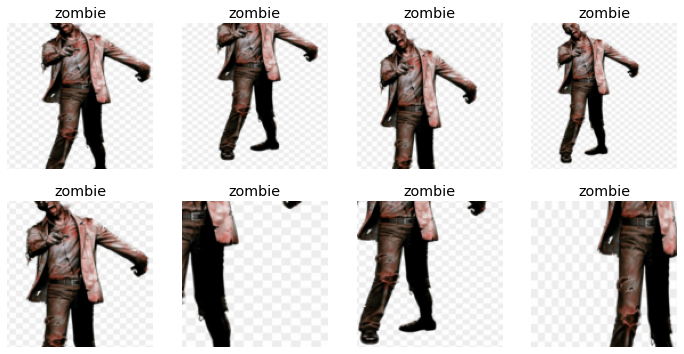

In [9]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training the model
We will now create a new model using the data we gathered, and we will perform a data cleanup using the image classifier cleaner utility from FastAI. Something to take note is that I'm using now a larger size for the RandomResizedCrop and also I added the [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) method to the batch transforms which will provide a list of batch transform with default values to execute to the mini batch.

Finally, we will create a new learner with a resnet50 architecture. In the default example, which I'm basing my notebook, Jeremy uses resnet34 but I wanted to try to use a larger network and see how it would work.

In [10]:
monsters = monsters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = monsters.dataloaders(path)

### Fine Tune and Model Head

One important method and concept I learned in the course is fine_tune(). This method when called basically trains the model but only makes modifications to the parameters of the head of a model.

The head of a model is the top layer of a model; meaning that when we fine tune a model we are taking advantage of transferred learning; we are using the values of the previous layers that were trained to recognize some basic images and/or forms that can be useful regardless of the problem we are trying to solve.

An example of the starting layers detections are lines, curves, circles, basic forms, etc.

In [11]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.996539,1.241446,0.353211,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.905812,0.716659,0.211009,00:19
1,0.711507,0.813167,0.192661,00:18
2,0.576557,0.609035,0.133028,00:19
3,0.450786,0.601878,0.151376,00:19
4,0.370991,0.593832,0.137615,00:19
5,0.309034,0.585341,0.146789,00:18


### Top Losses Review

After our model has trained we will use the confusion matrix to generate a graph that will help us understand the failures in predictions and later. This method is one of my most favorite one since it really helps people understand what's going on with our model.

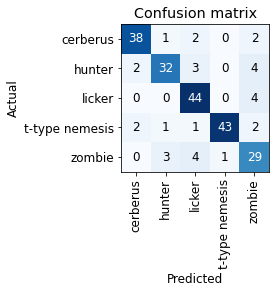

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

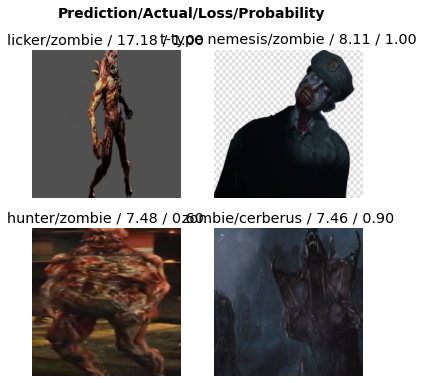

In [13]:
interp.plot_top_losses(4, nrows=2)

### Data Cleaning
As we can see from the top loss review we can try to fix our data and try to enhance our model performance. Something I learned from the course is that the model is going to be as good as your data is, thats why a lot of people spend a lot of time cleaning up data sets and preparing them and also why in most cases (like for this blog post) we spend more time in the next steps:

1. Review loss and performance
2. Clean up the data we are using for training
3. Clean up validation data since it might have labeling issues
4. Retrain our model with a new cleaner data set


The next lines of code will help us execute our image cleaning process. We will review the images of the data set and use that to retrain the model.

#### Important
The next cleaning process is done in 2 steps:

1. Use the cleaning widget and select the correcting action to be performed on the images
1. Execute the functions below the cleaner since that will be used to actually remove the images

In [14]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [15]:
#hide_output
for idx in cleaner.delete(): 
    print('Unlinking image: ' + str(cleaner.fns[idx]))
    cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): 
    filename = os.path.dirname(str(cleaner.fns[idx]))+ '/' + cat + '_' + os.path.basename(str(cleaner.fns[idx]))
    os.rename(str(cleaner.fns[idx]),filename)
    print('Moving image to ' + filename)
    shutil.move(filename, path/cat)

### Production Inference
The last I want to talk about is that we should prototype as much as we can. We can spend and absurd amount of time trying to gather data, cleaning and training but at some point we need to make sure we release it, put it in production and test it out in the open with real data.

In the case of our Resident Evil model I took a couple of screenshots from RE3 and gave it a go. I passed an image of a Hunter and I obtained decent results. Having said that making sure the application is usable by other people other than us its easier said than done. Fortunately, there are several tools we can use in Jupyter and FastAI to create a small UI, so we can prototype what we have done in a user friendly way.

In the next lines of code we will be exporting our model, then, using the load_learner function, we can load the new model for inference.

In [16]:
learn.export() # This is exporting our DL model into a pkl file our app can use for inference
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [17]:
learn_inf = load_learner(path/'export.pkl')

### Widgets, Widgets and More Widgets
In the course they taught us how to use Widgets in Jupyter. Widgets allow us to create a UI that can help us prototype and interact with the DL model. Let's use the widgets to create a web application for our new Resident Evil Detector.

Something important to mention is that there are several services we can use to host the app and if you are a web developer you can use different frameworks to develop a very cool web app.

Some examples can be found in [Chapter 2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb#Deploying-your-app) of the FastBook.

In [18]:
### Upload Btn
btn_upload = widgets.FileUpload()
btn_upload

### classification btn
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()

### Prediction Label
lbl_pred = widgets.Label()

### Function to classify images when the btn is pressed
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

### Attach function to onclick event for the javascript btn
btn_run.on_click(on_click_classify)

#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [19]:
### Widget definition where we are selecting an image and then using it for prediction
VBox([widgets.Label('Detect RE Monster'), 
      btn_upload, btn_run, out_pl, lbl_pred])

![Small UI](my_icons/REDetector_UI.png)

Finally we have a new UI and we should be ready to prototype our Resident Evil Detector. I hope you enjoyed the post and also feel free to use and make modifications you can find it on my github and its already a Jupyter Notebook so you can grab the blog post and use it to pilot things out or to add more categories to the detector.

Thanks for taking the time to read my post and have an awesome rest of your day.

#### References
* *[Fixes for corrupt data EXIF](https://stackoverflow.com/questions/44401114/how-can-i-identify-the-images-with-possibly-corrupt-exif-data)*
* *[Resident Evil 3](https://www.residentevil.com/3/), https://www.residentevil.com/3/*
* *[Fast AI Course V4 Lesson 2](https://course.fast.ai/videos/?lesson=2), https://course.fast.ai/videos/?lesson=2*
* *[FastAI Documentation aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms)*


This blog post is under Fair Use:
Copyright Disclaimer Under Section 107 of the Copyright Act in 1976; Allowance is made for "Fair Use" for purposes such as criticism, comment, news reporting, teaching, scholarship, and research.
Fair use is a use permitted by copyright statute that might otherwise be infringing. Non-profit, educational or personal use tips the balance in favor of fair use.

All rights and credit go directly to its rightful owners. No copyright infringement intended.

Enjoy.